# **The Problem: Automatic Apparent Age Estimation**
Author: Gerard Castro & Àlex Pujol

Last modified: Mar 14, 2023.

---



---
---
############### **Bias mitigation strategies** ###############
---
---
---

# Accuracy is not enough! We also need to evaluate how biased is our model!
- Next, we define different different functions, used to compute a bias score given different attributes.
  - Age bias (4 sub-groups)
  - Gender bias (2 sub-groups) 
  - Ethnicity bias (3 sub-groups)
  - Facial Expression bias (4 sub-groups)
- In a nutshell, given a particular attribute $A$, we compute the Mean Absolute Error $E_n$ for its $N$ sub-groups. We illustrate this process for the case of **Age** next:
- Consider we have 4 sub-groups base on different age ranges (i.e., "0-19", "20-39", "40-59", and "60-100"). We will have one error value per sub-group: $E_1$, $E_2$, $E_3$ and $E_4$.
- Then, we compute the absolute difference among them all. Consider $D$ is a squared matrix where each element $(i,j)$ is the absolute difference between $E_i$ and $E_j$. Then we can retrieve:
  - $D_{2,1} = |E_1-E_2|$
  - $D_{3,1} = |E_1-E_3|$
  - $D_{4,1} = |E_1-E_4|$
  - $D_{3,2} = |E_2-E_3|$
  - $D_{4,2} = |E_2-E_4|$
  - $D_{4,3} = |E_3-E_4|$

- The Final Bias score $B_A$ for attribute $A$ is obtained by the Average of the computed differences. That is:
  - $B_A = \frac{(D_{2,1} + D_{3,1} + D_{4,1} + D_{3,2} + D_{4,2} + D_{4,3})}{6}$
  - In other words: 

   $B_A = \frac{1}{(N^2-N)/2}\sum_{i=1}^{N} \sum_{j=1}^{N} |E_i - E_j|, \forall i,j \in \mathbb{N}^*, \text{if } i < j$

- To minimize your bias score, given a particular attribute, you will need to minimize the absolute difference among the different sub-groups being evaluated. That is, part of your goal will be to make the $N$ sub-groups of each attribute $A$ to have similar errors $E_n$
- The big challenge here is to minimize **ALL** bias scores (i.e., age, gender, ethnicity and face expression).
- Next, we briefly detail the different attributes (and their sub-groups) where the bias scores are evaluated.

---
# Age Bias ($B_a$) 

- Evaluates how accurate the model is with respect to different age ranges.
  - sub-group 1: age < 20
  - sub-group 2: 20 <= age < 40
  - sub-group 3: 40 <= age < 60
  - sub-group 4: 60 <= age



# Gender Bias ($B_g$) 
- Evaluates how accurate the model is with respect to different gender.
  - sub-group 1: male
  - sub-group 2: female


# Ethnicity Bias ($B_e$)
- Evaluates how accurate the model is with respect to different ethnicity categories.
  - sub-group 1: asian
  - sub-group 2: afroamerican
  - sub-group 3: caucasian


# Face expression bias ($B_f$)
- Evaluates how accurate the model is with respect to different face expression categories.
  - sub-group 1: neutral
  - sub-group 2: slightlyhappy
  - sub-group 3: happy
  - sub-group 4: other


---
---
########### **Bias Mitigation (strategy 2)** ##############
---
---
---
# Strategies to improve Accuracy (i.e., to reduce the Error):
# **2) Custom Loss:** sample weights to deal with inbalanced categories
- Next, we will created a "customized loss", which gives more weight to people having less samples in train data. For this simple example, **we will consider the age range only**. This way, we believe the model will be able to generalize a little bit better to those particular groups. Note that you are expect to build a more strong strategy, aiming to mitigate the bias with respect to all categories.

In [1]:
!pip install tensorflow==2.8.2
!pip install opencv-python
!pip install h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.9/497.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
from glob import glob
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder
from typing import List, Tuple
import random
import cv2
from builtins import zip
from zipfile import ZipFile
import h5py
import tensorflow as tf

_OUTPUT_PATH: str = '/kaggle/working'
_INPUT_PATH: str = '/kaggle/input/cv-age-app-data'

## Load the data (we'd do it again to remove the augmented data)

In [3]:
# loading the train data (with labels)
X_train = np.load(f'{_INPUT_PATH}/data/data_train.npy')
Y_train = np.load(f'{_INPUT_PATH}/data/labels_train.npy')
M_train = np.load(f'{_INPUT_PATH}/data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load(f'{_INPUT_PATH}/data/data_valid.npy')
Y_valid = np.load(f'{_INPUT_PATH}/data/labels_valid.npy')
M_valid = np.load(f'{_INPUT_PATH}/data/meta_data_valid.npy')

# loading the test data (images only) to be used later in our challenge
X_test = np.load(f'{_INPUT_PATH}/data/data_test.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train / 100
Y_valid = Y_valid / 100

## We preprocess the inputs accordingly to the selected backbone of the net 

In [4]:
BACKBONE: str = 'VGG19'  # 'ResNet50'  # 'VGG19'
assert BACKBONE in ('VGG19', 'ResNet50'), "Unrecognized backbone choice."

# INPUT PREPROCESSING: needed for ResNet-50 or VGG19
_input_preprocess: callable = tf.keras.applications.resnet50.preprocess_input if BACKBONE == 'ResNet50' else tf.keras.applications.vgg19.preprocess_input

# train
for i in range(0,X_train.shape[0]):
    x = X_train[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_train[i,] = _input_preprocess(x)

# validation
for i in range(0,X_valid.shape[0]):
    x = X_valid[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_valid[i,] = _input_preprocess(x)  

# test
for i in range(0,X_test.shape[0]):
    x = X_test[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    X_test[i,] = _input_preprocess(x)

# Generate the weigths 

## Baseline (original)

- First, we will generate a weight for each age group (for g =1 to 4);
- The formula used to calculate the weight for each group $j$ is:

  $w_j=n_{samples} / (n_{classes} * n_{samples,j}),$

  Where

    - $w_j$ is the weight for each group $j$,
    - $n_{samples}$ is the number of samples in the train set,
    - $n_{classes}$ is the number of classes (4 in our case, as we divided the ages in 4 groups),
    - $n_{samples,j}$ is the number of samples of class (group) $j$.

In [5]:
# # counting the number of samples per group in the train data (age attribute only)
# g1 = g2 = g3 = g4 = 0
# for i in range(0,Y_train.shape[0]):
#     if(Y_train[i]*100<20):
#         g1 +=1
#     if(Y_train[i]*100>=20 and Y_train[i]*100<40):
#         g2 +=1
#     if(Y_train[i]*100>=40 and Y_train[i]*100<60):
#         g3 +=1
#     if(Y_train[i]*100>=60):
#         g4 +=1
# print('group(s) size = ', [g1, g2, g3, g4])
# 
# # generating the weights for each group using the equation defined above
# w = sum(np.array([g1, g2, g3, g4]))/(4*np.array([g1, g2, g3, g4]))
# print('weights per group = ', w)
# 
# # creating a vector with same size as Y_train, that will link a particular label to its weight
# sample_weights = []
# for i in range(0,Y_train.shape[0]):
#     if Y_train[i]*100 < 20:
#         sample_weights.append(w[0])
#     if Y_train[i]*100 >= 20 and Y_train[i]*100<40:
#         sample_weights.append(w[1])
#     if Y_train[i]*100 >= 40 and Y_train[i]*100<60:
#         sample_weights.append(w[2])
#     if Y_train[i]*100 >= 60:
#         sample_weights.append(w[3])
# sample_weights = np.array(sample_weights)

## Our baseline (custom groups)

### Auxiliary visualization functions

In [6]:
####################################################################
# DISTRIBUTION VISUALIZATIONS
####################################################################

def _show_all_four_distributions(
        m_train: np.ndarray, m_val: np.ndarray, y_train: np.ndarray,
        y_val: np.ndarray) -> None:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle('Metadata & age distribution', fontsize=14, fontweight='bold')
    labels = ['Training', 'Validation']

    for _i_label, metadata_array in enumerate([m_train, m_val]):
        gender = []
        etnhicity = []
        emotion = []

        for _sample in metadata_array:
            gender.append(_sample[0])
            etnhicity.append(_sample[1])
            emotion.append(_sample[2])
        age = y_train if _i_label == 0 else y_val

        ax1.hist(gender, density=True, label=labels[_i_label], alpha=0.5)
        ax2.hist(etnhicity, density=True, label=labels[_i_label], alpha=0.5)
        ax3.hist(emotion, density=True, label=labels[_i_label], alpha=0.5)
        ax4.hist(age, density=True, label=labels[_i_label], alpha=0.5)

    fig.legend(labels)
    plt.savefig(f'{_OUTPUT_PATH}/train_val_histograms.png', dpi=150)
    plt.show()


def _show_the_age_distribution(y_train: np.ndarray, y_val: np.ndarray) -> None:
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 4))
    fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

    # labels are multiplied by 100 to show the original values
    ax1.hist(y_train * 100, bins=50, density=True, label='Train', alpha=0.5)
    ax1.hist(y_val * 100, bins=50, density=True, label='Validation', alpha=0.5)
    ax1.set_title('Age labels')
    ax1.set(xlabel='Apparent age', ylabel='Density')
    ax1.set_xlim([0, 100])
    fig.legend(['Train', 'Validation'])
    plt.show()


def _show_metadata_distribution(
        m_train: np.ndarray, m_val: np.ndarray) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    fig.suptitle('Metadata distribution', fontsize=14, fontweight='bold')
    labels = ['Training', 'Validation']

    for _i_label, metadata_array in enumerate([m_train, m_val]):
        gender = []
        etnhicity = []
        emotion = []

        for _sample in metadata_array:
            gender.append(_sample[0])
            etnhicity.append(_sample[1])
            emotion.append(_sample[2])

        ax1.hist(gender, density=True, label=labels[_i_label], alpha=0.5)
        ax2.hist(etnhicity, density=True, label=labels[_i_label], alpha=0.5)
        ax3.hist(emotion, density=True, label=labels[_i_label], alpha=0.5)
    fig.legend(labels)
    plt.show()


def show_distribution(_arrays: List[np.ndarray], labels: List[str]) -> None:
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 4))
    fig.suptitle('Categories distribution', fontsize=14, fontweight='bold')

    # labels are multiplied by 100 to show the original values
    for _i_l, _array in enumerate(_arrays):
        ax1.hist(_array, bins=len(np.unique(_array)), density=True,
                 alpha=0.5, label=labels[_i_l])
    ax1.set_title('Categories')
    ax1.set(xlabel='Category label', ylabel='Density')
    ax1.set_xlim([0, len(np.unique(_arrays[0]))])
    fig.legend(labels)
    plt.savefig(f'{_OUTPUT_PATH}/categories.png', dpi=150)
    plt.show()
    
    
def show_sample_weights_distribution(
        weights: List[np.ndarray], labels: List[str],
        file_name: str = 'sample_weights') -> None:
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 4))
    fig.suptitle('Sample weights distribution', fontsize=14, fontweight='bold')

    # labels are multiplied by 100 to show the original values
    for _i_l, _array in enumerate(weights):
        ax1.hist(_array, bins=50, density=True,
                 alpha=0.5, label=labels[_i_l])
    # ax1.set_title('Categories')
    ax1.set(xlabel='Weight value', ylabel='Density')
    # ax1.set_xlim([np.min(np.concatenate(weights)), np.max(np.concatenate(weights))])
    fig.legend(labels)
    plt.savefig(f'{_OUTPUT_PATH}/{file_name}.png', dpi=150)
    plt.show()

### Main custom functions

In [7]:
####################################################################
# MAIN FUNCTIONS
####################################################################

def create_sample_weights_vector(
        use_custom_weight: bool, _plot_categories: bool = False) -> np.ndarray:
    comp_categories: np.ndarray = create_compound_categories(Y_train, M_train)
    comp_dict: dict = create_count_dictionary(comp_categories)

    if use_custom_weight:
        sample_weights: np.ndarray = __define_custom_sample_weight(
            comp_categories, comp_dict)
    else:
        sample_weights: np.ndarray = __define_classic_sample_weight(
            comp_categories, comp_dict)

    if _plot_categories:
        show_distribution([comp_categories], ['Compound categories'])

    return sample_weights


def __define_classic_sample_weight(
        categories: np.ndarray, samples_count: dict,
        _corrected: bool = True) -> np.ndarray:
    """
    Compute the weight for each sample according to the baseline formula:

    omega_j = log \frac{n_samples}{n_{classes} * n_{samples, j}}

    Parameters
    ----------
    categories: np.ndarray
        Categories vector Y_train-like containing the category label
        for each sample
    samples_count: dict
        Dictionary containing the number of samples (value) for each
        category label (key)
    _corrected: bool
        If True, then a log-transform is applied to the formula to
        avoid outliers

    Returns
    -------
    weights: np.ndarray
        Sample weights vector Y_train-like containing the category-weight
        for each sample

    """
    n_samples: int = categories.shape[0]
    n_classes: int = len(samples_count)
    weights: np.ndarray = np.full(categories.shape, np.nan)
    for _j in range(n_samples):
        n_samples_j = samples_count[categories[_j]]
        weights[_j] = n_samples / (n_classes * n_samples_j)

    if not _corrected:
        return weights

    log_transformed: np.ndarray = np.log(weights + 1)
    _normalization = np.sum(log_transformed) / n_samples

    return log_transformed / _normalization


def __define_custom_sample_weight(
        categories: np.ndarray, samples_count: dict) -> np.ndarray:
    """
    Compute the weight for each sample according to the baseline formula:

    omega_j = \frac{n_samples}{n_{classes} * n_{samples, j}}

    Parameters
    ----------
    categories: np.ndarray
        Categories vector Y_train-like containing the category label
        for each sample
    samples_count: dict
        Dictionary containing the number of samples (value) for each
        category label (key)

    Returns
    -------
    weights: np.ndarray
        Sample weights vector Y_train-like containing the category-weight
        for each sample

    """
    n_samples: int = categories.shape[0]
    n_classes: int = len(samples_count)
    weights: np.ndarray = np.full(categories.shape, np.nan)
    for _j in range(n_samples):
        n_samples_j = samples_count[categories[_j]]
        weights[_j] = np.log(1 + n_samples) / (n_classes * np.log(1 + n_samples_j))
    return weights


####################################################################
# MAIN WRAPPERS
####################################################################

def create_compound_categories(y_array, m_array) -> np.ndarray:
    age_train: np.ndarray = _age_to_group(y_array)
    categories_train: np.ndarray = _metadata_to_group(m_array)
    comp_categories: np.ndarray = _create_compound_categories(
        age_train, categories_train)
    return comp_categories


def create_count_dictionary(cat_array: np.ndarray) -> dict:
    unique, counts = np.unique(cat_array, return_counts=True)
    return dict(zip(unique, counts))


####################################################################
# AUXILIARY FUNCTIONS
####################################################################

def _create_compound_categories(
        age_array: np.ndarray, categories_array: np.ndarray) -> np.ndarray:
    _c: np.ndarray = np.concatenate(
        [age_array.reshape(-1, 1), categories_array], axis=1). \
        astype(int).astype(str)

    _hash_arr = np.char.add(
        _c[:, 0], np.char.add(_c[:, 1], np.char.add(_c[:, 2], _c[:, 3])))

    return LabelEncoder().fit_transform(_hash_arr)


def _age_to_group(y_array: np.ndarray) -> np.ndarray:
    return np.vectorize(__age_to_group)(y_array)


def __age_to_group(age: float) -> int:
    _groups: dict = {
        0: 0. <= age * 100 < 20., 1: 20. <= age * 100 < 40.,
        2: 40. <= age * 100 < 60., 3: 60. <= age * 100 < 100}
    for _k, _v in _groups.items():
        if _v:
            return _k
    raise ValueError(f"Unexpected age value: {age}!")


def _metadata_to_group(m_array: np.ndarray) -> np.ndarray:
    categories_train = np.full(m_array.shape, np.nan)
    for _j in range(m_array.shape[1]):
        categories_train[:, _j] = LabelEncoder().fit_transform(m_array[:, _j])
    return categories_train

### Sample weights vector declaration

In [8]:
sample_weights: np.ndarray = create_sample_weights_vector(False)

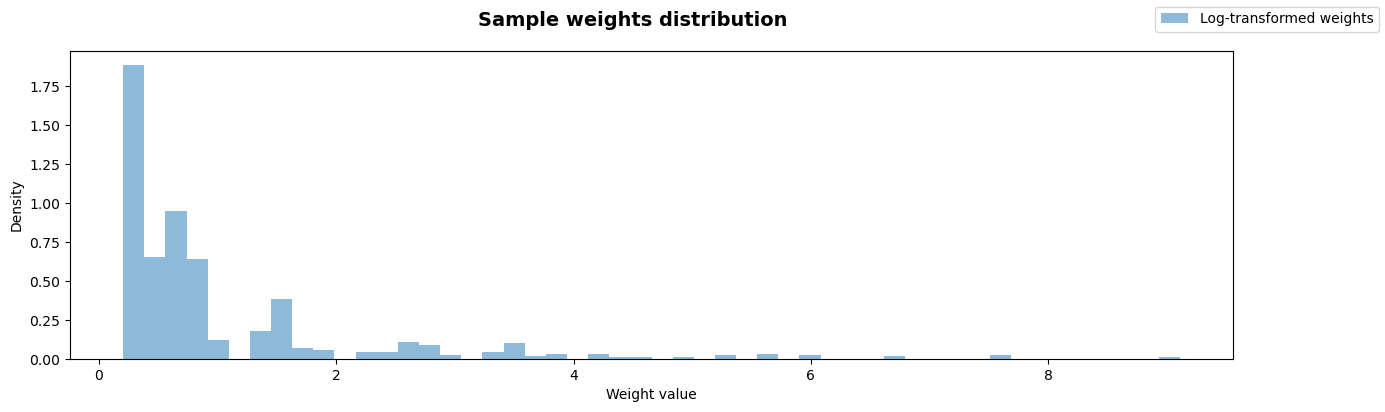

In [9]:
show_sample_weights_distribution([sample_weights], ['Log-transformed weights'])

# I) Using the SAMPLE WEIGHTS to train our model and,
- Next, you will see the code we used to train our model (2nd stage) from the model we obtained at the 1st stage, using the customized loss option with sample weights.
- As default, the code will load the model already trained. 
- You can change the boolean variable 'LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS' to False to train your model.
- Note, now we include other variables ('RESUME_TRAINING' and 'RESUME_FROM_EPOCH') to allow us resuming training, as well as to inform from what epoch we want to resume the trainind, detailed below.

# II) illustrating how to train + save + stop training + RESUME TRAINING
- **Imagine** you set 'LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS = False', 'NUM_EPOCHS = 12' and 'RESUME_TRAINING = False' to train your model the first time.
- Due to Colab limitations, your process stoped the training at the middle of epoch 10, and you saved the best model based on validation loss on epoch 9.
- In the above example, you can resume training from epoch 9 by setting the following parameters:
  - 'RESUME_TRAINING = True'
  - 'RESUME_FROM_EPOCH = 9'

- IMPORTANT: to resume training, you will need to monitor the epoch number where your model stopped before resuming the training, and change the defined variables properly. 
  - Note that the fit function is adapted to receive the sample weights ('sample_weight=sample_weights').
  - Also note that the fit function changes if you are training from epoch 0 (initial_epoch=0) or resume training (initial_epoch=RESUME_FROM_EPOCH). 
  - Finally, note that when you are resuming training, you load your 'best_model_2nd_stage_weighted.h5' instead of the model trained at stage 1 ('best_model.h5').
if not SKIP_NEW_CELLS:

# Training strategy

## We use the 2-stage training strategy: in the 1st one just the FC layers are trained, in the 2nd one the whole model is trained

#### We can deactivate the 1st training stage or activate it (the latter is useful if the backbone is desired to be changed)

In [10]:
# FIRST STAGE
#--------------------------
LOAD_BEST_MODEL_ST1_WEIGHTED_LOSS = False  # False  # True  # if False, then the 1st stage training is also carried out 
# just if 'LOAD_BEST_MODEL_ST1_WEIGHTED_LOSS = False'
_EPOCHS_1ST_STAGE: int = 60

# SECOND STAGE
#--------------------------
LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS = False
NUM_EPOCHS = 75
LEARNING_RATE_ST1: float = 1e-5
LEARNING_RATE_ST2: float = 5e-5
#--------------------------
RESUME_TRAINING = False
RESUME_FROM_EPOCH = 25
#--------------------------

## First stage

#### The first model output is saved as ``best_model.h5``

In [11]:
if LOAD_BEST_MODEL_ST1_WEIGHTED_LOSS:
    # nothing is done, the trained st1 model is download and saved as 'best_model.h5'
    !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st1.zip
    # decompressing the data
    with ZipFile('best_model_st1.zip','r') as zip:
        zip.extractall()
    print('Model decompressed successfully')
    
    # removing the .zip file after extraction  to clean space
    !rm best_model_st1.zip
else:
    # WE DOWNLOAD THE RESNET50
    if BACKBONE == 'ResNet50':
        if not os.path.isfile(f'{_OUTPUT_PATH}/model/weights.h5'):
            # downloading the data
            !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip

            # decompressing the data
            with ZipFile(f'{_OUTPUT_PATH}/model.zip','r') as _zip:
                _zip.extractall()
                print('Model decompressed successfully')

            # removing the .zip file after extraction  to clean space
            !rm model.zip

        # we load the pretrained model, add some layers & train the last FC layers
        # then the model is saved as best_model.h5
        model = tf.keras.models.load_model(f'{_OUTPUT_PATH}/model/weights.h5')
    else:
        model = tf.keras.applications.VGG19()
        
    # Using the FC layer before the 'classifier_low_dim' layer as feature vector
    if BACKBONE == 'ResNet50':
        fc_512 = model.get_layer('dim_proj').output
    else:
        fc_512 = model.get_layer('fc2').output

    if BACKBONE == 'VGG19':
        # we freeze the layers here
        for layers in model.layers:
            layers.trainable = False

    # adding a dropout layer to minimize overfiting problems
    dp_layer = tf.keras.layers.Dropout(0.5)(fc_512)
    # adding a few hidden FC layers to learn hidden representations
    # fc_128 = tf.keras.layers.Dense(128, activation='relu', name='f_128')(fc_512)
    # fc_32 = tf.keras.layers.Dense(32, activation='relu', name='f_32')(fc_128)
    fc_32 = tf.keras.layers.Dense(32, activation='relu', name='f_32')(fc_512)

    # Includint an additional FC layer with sigmoid activation, used to regress
    # the apparent age
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='predict')(fc_32)

    # building the final model
    if BACKBONE == 'ResNet50':
        model = tf.keras.models.Model(inputs=model.get_layer('base_input').output,outputs=output)
    else:
        model = tf.keras.models.Model(inputs=model.layers[0].output,outputs=output)

    if BACKBONE == 'ResNet50':
        # we freeze the first layers (belonging to the Resnet)
        counter = 0
        for layer in model.layers:
            if counter <= 174: 
                layer.trainable = False
            else:
                layer.trainable = True
            counter +=1

    # defining the early stop criteria
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    # saving the best model based on val_loss
    mc = tf.keras.callbacks.ModelCheckpoint(f'{_OUTPUT_PATH}/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

    # defining the optimizer
    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ST1),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

    # training the model
    history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=_EPOCHS_1ST_STAGE, shuffle=True, verbose=1, callbacks=[es, mc])

    # saving training history (for future visualization)
    with open(f'{_OUTPUT_PATH}/train_history_1st_stage.pkl', 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

574726144/574710816 [==============================] - 4s 0us/step
Epoch 1/60
128/128 [==============================] - 46s 258ms/step - loss: 0.0678 - mae: 0.2098 - val_loss: 0.0487 - val_mae: 0.1782
Epoch 2/60
128/128 [==============================] - 31s 247ms/step - loss: 0.0455 - mae: 0.1715 - val_loss: 0.0404 - val_mae: 0.1601
Epoch 3/60
128/128 [==============================] - 32s 251ms/step - loss: 0.0373 - mae: 0.1533 - val_loss: 0.0352 - val_mae: 0.1487
Epoch 4/60
128/128 [==============================] - 34s 270ms/step - loss: 0.0321 - mae: 0.1414 - val_loss: 0.0318 - val_mae: 0.1407
Epoch 5/60
128/128 [==============================] - 32s 252ms/step - loss: 0.0287 - mae: 0.1330 - val_loss: 0.0294 - val_mae: 0.1348
Epoch 6/60
128/128 [==============================] - 32s 253ms/step - loss: 0.0263 - mae: 0.1271 - val_loss: 0.0277 - val_mae: 0.1302
Epoch 7/60
128/128 [==============================] - 33s 255ms/step - loss: 0.0246 - mae: 0.1225 - val_loss: 0.0265 - val_

### Visualization of the 1st stage training history

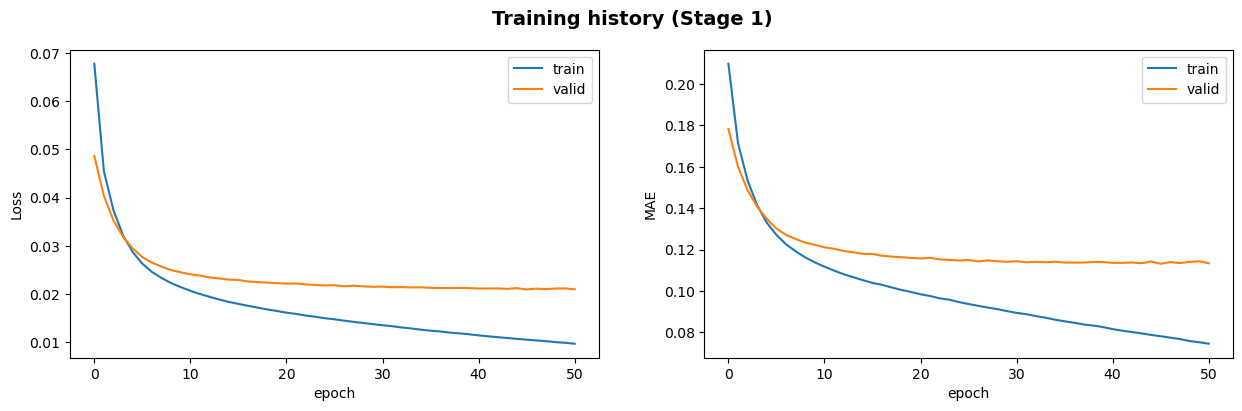

In [12]:
if not LOAD_BEST_MODEL_ST1_WEIGHTED_LOSS:
    train_hist_1st = history.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle('Training history (Stage 1)', fontsize=14, fontweight='bold')

    ax1.plot(train_hist_1st['loss'])
    ax1.plot(train_hist_1st['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist_1st['mae'])
    ax2.plot(train_hist_1st['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')
    plt.savefig(f'{_OUTPUT_PATH}/train_history_aug_1st_stage.png', dpi=150)

## Second stage

#### The first stage output model has been already saved as ``best_model.h5``, the output model of this 2nd stage will be saved as ``best_model_2nd_stage_weighted.h5``

In [13]:
if LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS == True:
    # downloading the trained model for the 2nd stage
    !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_weighted.zip
    # decompressing the data
    with ZipFile('best_model_weighted.zip','r') as _zip:
        _zip.extractall()
    print('Model decompressed successfully')
    # removing the .zip file after extraction  to clean space
    !rm best_model_weighted.zip

else:
    # loading the saved model (best model learned at stage 1)
    if RESUME_TRAINING == False:
        saved_model = tf.keras.models.load_model(f'{_OUTPUT_PATH}/best_model.h5') # load model from stage 1
    else:
        # resume training (stage 2)
        saved_model = tf.keras.models.load_model(f'{_OUTPUT_PATH}/best_model_2nd_stage_weighted.h5')
    
    # setting all layers to traineable
    saved_model.trainable = True

    #=================================================
    # training all layers (2nd stage), given the model saved on stage 1
    saved_model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ST2),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
    #=================================================

    # defining the early stop criteria
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint(f'{_OUTPUT_PATH}/best_model_2nd_stage_weighted.h5', monitor='val_loss', mode='min', save_best_only=True)

    if(RESUME_TRAINING == False):  
        history = saved_model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=0, shuffle=True, verbose=1, callbacks=[es, mc])
    else:
        history = saved_model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=RESUME_FROM_EPOCH, shuffle=True, verbose=1, callbacks=[es, mc])

Epoch 1/75
255/255 [==============================] - 94s 345ms/step - loss: 0.0385 - mae: 0.1256 - val_loss: 0.0256 - val_mae: 0.1324
Epoch 2/75
255/255 [==============================] - 79s 311ms/step - loss: 0.0325 - mae: 0.1204 - val_loss: 0.0306 - val_mae: 0.1453
Epoch 3/75
255/255 [==============================] - 90s 353ms/step - loss: 0.0234 - mae: 0.1029 - val_loss: 0.0165 - val_mae: 0.0996
Epoch 4/75
255/255 [==============================] - 90s 351ms/step - loss: 0.0168 - mae: 0.0927 - val_loss: 0.0131 - val_mae: 0.0874
Epoch 5/75
255/255 [==============================] - 80s 312ms/step - loss: 0.0111 - mae: 0.0821 - val_loss: 0.0131 - val_mae: 0.0885
Epoch 6/75
255/255 [==============================] - 90s 353ms/step - loss: 0.0072 - mae: 0.0697 - val_loss: 0.0121 - val_mae: 0.0860
Epoch 7/75
255/255 [==============================] - 80s 313ms/step - loss: 0.0054 - mae: 0.0628 - val_loss: 0.0122 - val_mae: 0.0837
Epoch 8/75
255/255 [==============================] - 9

### Visualization of the 2nd training stage history

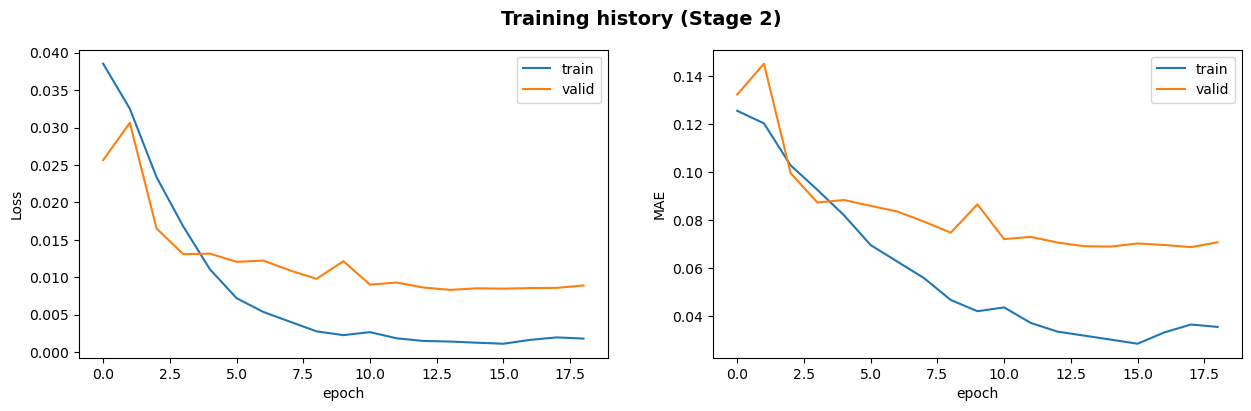

In [14]:
try:
    if LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS == True:
        train_hist_2nd = pickle.load(open(f"{_OUTPUT_PATH}/train_history_2nd_stage.pkl","rb"))
    else:
        train_hist_2nd = history.history
        with open(f'{_OUTPUT_PATH}/train_history_2nd_stage.pkl', 'wb') as handle:
            pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle('Training history (Stage 2)', fontsize=14, fontweight='bold')

    ax1.plot(train_hist_2nd['loss'])
    ax1.plot(train_hist_2nd['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist_2nd['mae'])
    ax2.plot(train_hist_2nd['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')
    plt.savefig(f'{_OUTPUT_PATH}/train_history_aug_better_training.png', dpi=150)
except ValueError as error:
    _msg: str = "There is an incompatibility problem with the pickle version used to serialize the train_history.pkl!"
    print(_msg)
    # raise ValueError(_msg) from error
    
    train_hist_2nd = history.history
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

    ax1.plot(train_hist_2nd['loss'])
    ax1.plot(train_hist_2nd['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist_2nd['mae'])
    ax2.plot(train_hist_2nd['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')
    plt.savefig(f'{_OUTPUT_PATH}/train_history_aug_better_training.png', dpi=150)
except FileNotFoundError:
    print("The training history for the 2nd stage could not be retrieved")

# Making predictions on the Validation set and Evaluating
if not SKIP_NEW_CELLS:- Note that in this case, the model obtained MAE = 11.32504168, which is not the best score compared to the ones obtained before. However, are the evaluated biases better? Let's see!

## Predicting

In [15]:
saved_model_2nd_weighted = tf.keras.models.load_model(f'{_OUTPUT_PATH}/best_model_2nd_stage_weighted.h5')
# predict on the test data
predictions_st2_weighted = saved_model_2nd_weighted.predict(X_valid, batch_size=32, verbose=1)
# re-scaling the output predictions (from [0,1] to age range) using the
# the normalization factor mentioned before
predictions_st2_weighted_final = predictions_st2_weighted * 100

47/47 [==============================] - 8s 173ms/step


## Evaluating and comparing the 2nd stage of training on validation set: 
**case a)** without augmentation/custom loss *vs.* **case b)** without augmentation but with custom loss.

In [16]:
if not os.path.isfile(f'{_OUTPUT_PATH}/bias_functions.py'):
    !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/bias_functions.py

# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

--2023-03-13 08:55:59--  http://data.chalearnlap.cvc.uab.cat/Colab_2021/bias_functions.py
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4355 (4.3K) [application/octet-stream]
Saving to: ‘bias_functions.py’

bias_functions.py   100%[===================>]   4.25K  --.-KB/s    in 0s      

2023-03-13 08:56:00 (319 MB/s) - ‘bias_functions.py’ saved [4355/4355]



In [17]:
# Evaluating MAE on Validation data
error = []
for i in range(0,len(Y_valid)):
    error.append(abs(np.subtract(predictions_st2_weighted_final[i][0],Y_valid[i]*100)))
print('MAE (Validation) = %.8f' %(np.mean(error)))

# printing some predictions
# for i in range(0,20):
#     print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st2_weighted_final[i], Y_valid[i]*100))

# Evaluating biases on Validation data
age_bias(predictions_st2_weighted_final,Y_valid * 100)
gender_bias(predictions_st2_weighted_final,Y_valid * 100, M_valid)
ethnicity_bias(predictions_st2_weighted_final,Y_valid * 100, M_valid)
face_expression_bias(predictions_st2_weighted_final,Y_valid * 100,M_valid)

MAE (Validation) = 6.92060249
Age analysis:
Size group 1 = 305, MAE = 8.305459
Size group 2 = 841, MAE = 5.728799
Size group 3 = 275, MAE = 7.802992
Size group 4 = 61, MAE = 12.449599
---------
Age bias (Ba) =  3.4441445668538413
Gender analysis:
Size group female = 716, MAE = 6.811499
Size group male = 766, MAE = 7.022585
---------
Gender bias (Bg) =  0.21108627
Ethnicity Analysis:
Size group asian = 116, MAE = 6.397519
Size group afroamerican = 50, MAE = 5.825934
Size group caucasian = 1316, MAE = 7.008301
---------
Ethnicity bias (Be) =  0.7882445653279623
Face experession Analysis:
Size group happy = 403, MAE = 7.095481
Size group slightlyhappy = 476, MAE = 6.874053
Size group neutral = 492, MAE = 6.615034
Size group other = 111, MAE = 7.839714
---------
Face Expression bias (Bf) =  0.6492445468902588


## Saving the predictions **on the test set** as a predictions.zip 

In [18]:
# custom loss /task 2
saved_model_2nd_weighted = tf.keras.models.load_model(f'{_OUTPUT_PATH}/best_model_2nd_stage_weighted.h5')
predictions_st2_custom_loss_test = saved_model_2nd_weighted.predict(X_test, batch_size=32, verbose=1)
predictions_st2_custom_loss_test_f = predictions_st2_custom_loss_test*100

# # predictions_st2_custom_loss_test_f = predictions_st2_weighted_final

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(predictions_st2_custom_loss_test_f)
csvFile.close()
# compressing the csv file (to be submitted to codalab as prediction)
! zip experiment6.zip predictions.csv

62/62 [==============================] - 14s 219ms/step
  adding: predictions.csv (deflated 55%)
